<a href="https://colab.research.google.com/github/vkjdinesh/Reseacrh/blob/main/FID_progressmeeting_Jan29%2C2023.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

FID of Images

In [ ]:
#library
import os
import cv2
import glob
import matplotlib.pyplot as plt 
from tensorflow.keras.applications import InceptionV3
import numpy
import numpy as np
from numpy import cov
from numpy import trace
from numpy import iscomplexobj
from numpy import asarray
from numpy.random import shuffle
from scipy.linalg import sqrtm
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input
from keras.datasets.mnist import load_data
from skimage.transform import resize
import numpy as np
import  scipy
import numpy as np
from scipy.linalg import sqrtm
import cmath

In [ ]:
#folder path
path = "/content/drive/MyDrive/animals/raw-img/scoiattolo"

In [ ]:
images = os.listdir(path)

In [ ]:
#create a list 
img_data=[]
for img in images:
    img_arr=cv2.imread(os.path.join(path,img))
    img_data.append(img_arr)

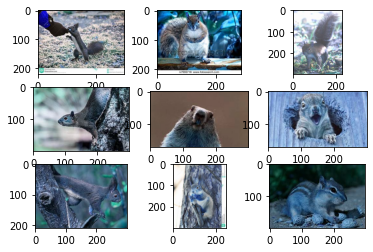

In [ ]:
#show the images
for i in range(len(img_data[:9])):
    plt.subplot(3,3,i+1)
    plt.imshow(img_data[i])

In [ ]:
#check the len
print(len(img_data))
print(type(img_data))

1863
<class 'list'>


In [ ]:
#select the images for FID
images1 = img_data[0:100]
images2 = img_data[101:201]
print(len(images1))
print(len(images2))

100
100


In [ ]:
#change the size
def scale_images(images, new_shape):
    images_list = list()
    for image in images:
        # resize with nearest neighbor interpolation
        new_image = resize(image, new_shape, 0)
        images_list.append(new_image)
    return asarray(images_list)

In [ ]:
# calculate the FID
def calculate_fid(model, images1, images2):
    # feature extraction
    act1 = model.predict(images1)
    act2 = model.predict(images2)
    # calculate mean and covariance 
    mu1, sigma1 = act1.mean(axis=0), cov(act1, rowvar=False)
    mu2, sigma2 = act2.mean(axis=0), cov(act2, rowvar=False)
    # calculate sum squared difference between means
    ssdiff = numpy.sum((mu1 - mu2)**2.0)
    # calculate sqrt of product between cov
    covmean = sqrtm(sigma1.dot(sigma2))
    if iscomplexobj(covmean):
        covmean = covmean.real
    # calculate score
    fid = ssdiff + trace(sigma1 + sigma2 - 2.0 * covmean)
    return fid

In [ ]:
#inception model
model = InceptionV3(include_top=False, pooling='avg', input_shape=(299,299,3))

87910968/87910968 [==============================] - 1s 0us/step


In [ ]:
#resize and preprocess
images1 = scale_images(images1, (299,299,3))
images2 = scale_images(images2, (299,299,3))
print('Scaled', images1.shape, images2.shape)
# pre-process images
images1 = preprocess_input(images1)
images2 = preprocess_input(images2)

Scaled (100, 299, 299, 3) (100, 299, 299, 3)


In [ ]:
#calculate the FID
calculate_fid(model, images1, images1)

4/4 [==============================] - 20s 5s/step


-1.6973843365693666e-06

In [ ]:
#calculate the FID
calculate_fid(model, images1, images2)

4/4 [==============================] - 21s 5s/step


1.3187808617063457

FID of Basic GAN(MNIST) 

In [25]:
from __future__ import print_function, division

from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam

import matplotlib.pyplot as plt

import sys

import numpy as np

class DCGAN():
    def __init__(self):
        # Input shape
        self.img_rows = 28
        self.img_cols = 28
        self.channels = 1
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.latent_dim = 100

        optimizer = Adam(0.0002, 0.5)

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy',
            optimizer=optimizer,
            metrics=['accuracy'])

        # Build the generator
        self.generator = self.build_generator()

        # The generator takes noise as input and generates imgs
        z = Input(shape=(self.latent_dim,))
        img = self.generator(z)

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The discriminator takes generated images as input and determines validity
        valid = self.discriminator(img)

        # The combined model  (stacked generator and discriminator)
        # Trains the generator to fool the discriminator
        self.combined = Model(z, valid)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)

    def build_generator(self):

        model = Sequential()

        model.add(Dense(128 * 7 * 7, activation="relu", input_dim=self.latent_dim))
        model.add(Reshape((7, 7, 128)))
        model.add(UpSampling2D())
        model.add(Conv2D(128, kernel_size=3, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Activation("relu"))
        model.add(UpSampling2D())
        model.add(Conv2D(64, kernel_size=3, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Activation("relu"))
        model.add(Conv2D(self.channels, kernel_size=3, padding="same"))
        model.add(Activation("tanh"))

        model.summary()

        noise = Input(shape=(self.latent_dim,))
        img = model(noise)

        return Model(noise, img)

    def build_discriminator(self):

        model = Sequential()

        model.add(Conv2D(32, kernel_size=3, strides=2, input_shape=self.img_shape, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
        model.add(ZeroPadding2D(padding=((0,1),(0,1))))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(256, kernel_size=3, strides=1, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Flatten())
        model.add(Dense(1, activation='sigmoid'))

        model.summary()

        img = Input(shape=self.img_shape)
        validity = model(img)

        return Model(img, validity)

    def train(self, epochs, batch_size=128, save_interval=50):

        # Load the dataset
        (X_train, _), (_, _) = mnist.load_data()

        # Rescale -1 to 1
        X_train = X_train / 127.5 - 1.
        X_train = np.expand_dims(X_train, axis=3)

        # Adversarial ground truths
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))

        for epoch in range(epochs):

            # ---------------------
            #  Train Discriminator
            # ---------------------

            # Select a random half of images
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            imgs = X_train[idx]

            # Sample noise and generate a batch of new images
            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
            gen_imgs = self.generator.predict(noise)

            # Train the discriminator (real classified as ones and generated as zeros)
            d_loss_real = self.discriminator.train_on_batch(imgs, valid)
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # ---------------------
            #  Train Generator
            # ---------------------

            # Train the generator (wants discriminator to mistake images as real)
            g_loss = self.combined.train_on_batch(noise, valid)

            # Plot the progress
            print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))

            # If at save interval => save generated image samples
            if epoch % save_interval == 0:
                self.save_imgs(epoch)
    def save_imgs(self, epoch):
        r, c = 2,2
        #noise = np.random.normal(0, 1, (r * c, self.latent_dim))
        noise = np.random.normal(0, 1, (r * c, self.latent_dim))
        gen_imgs = self.generator.predict(noise)

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
                axs[i,j].axis('off')
                cnt += 1
        fig.savefig("images/mnist_%d.png" % epoch)
        plt.close()


In [26]:
if __name__ == '__main__':
    dcgan = DCGAN()
    dcgan.train(epochs=1000, batch_size=32, save_interval=10)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_94 (Conv2D)          (None, 14, 14, 32)        320       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 14, 14, 32)        0         
                                                                 
 dropout (Dropout)           (None, 14, 14, 32)        0         
                                                                 
 conv2d_95 (Conv2D)          (None, 7, 7, 64)          18496     
                                                                 
 zero_padding2d (ZeroPadding  (None, 8, 8, 64)         0         
 2D)                                                             
                                                                 
 batch_normalization_94 (Bat  (None, 8, 8, 64)         256       
 chNormalization)                                       

In [27]:
#load mnist real images
(X_train, _), (_, _) = mnist.load_data()

In [40]:
mnist_images1 = X_train[0:100]
print(len(mnist_images1))

100


In [34]:
mnist_path = "/content/images"

In [35]:
mnist_images = os.listdir(mnist_path)

In [38]:
mnitimg_data=[]
for img in mnist_images:
    img_arr=cv2.imread(os.path.join(mnist_path,img))
    mnitimg_data.append(img_arr)

In [39]:
len(mnitimg_data)

100

In [44]:
mnist_images2 = mnitimg_data[0:100]
len(mnist_images2)

100

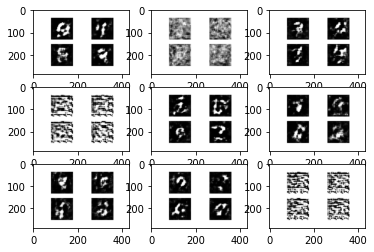

In [41]:
for i in range(len(mnitimg_data[:9])):
    plt.subplot(3,3,i+1)
    plt.imshow(mnitimg_data[i])

In [48]:

# resize images
mnist_images1 = scale_images(mnist_images1, (299,299,3))
mnist_images2 = scale_images(mnist_images2, (299,299,3))
print('Scaled', mnist_images1.shape, mnist_images2.shape)
# pre-process images
mnist_images1 = preprocess_input(mnist_images1)
mnist_images2= preprocess_input(mnist_images2)


Scaled (100, 299, 299, 3) (100, 299, 299, 3)


In [49]:
calculate_fid(model, mnist_images1, mnist_images2)

4/4 [==============================] - 21s 5s/step


7.975668778874115e-08

In [50]:
calculate_fid(model, mnist_images1, mnist_images1)

4/4 [==============================] - 20s 5s/step


-4.561655131494551e-15